<a href="https://colab.research.google.com/github/mgozon/DLG-UROP/blob/main/Batch_DLG_Evolution_Iris_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch-DLG Evolution - Iris Dataset
This notebook is based on the [Batch-DLG Iris Dataset](https://github.com/mgozon/DLG-UROP/blob/main/Batch_DLG_Iris_Dataset.ipynb), which implements the procedure in [Deep Leakage from Gradients](https://gist.github.com/Lyken17/91b81526a8245a028d4f85ccc9191884) on the Iris Dataset. In particular, a fully connected nueral network is trained using mini-batch gradients which are leaked.

# Setting up Libaries and Utilities

In [1]:
# setting up machine learning/visualization libraries
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
#torch.manual_seed(100) # for generating the same random weights
from torch.utils.data import RandomSampler
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler

# setting up optimal device
print(torch.__version__)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

# utilities for testing
from random import randint
from random import shuffle
from itertools import permutations
from scipy.optimize import linear_sum_assignment
import math

1.13.0+cu116
Running on cpu


# Setting up Fully Connected Neural Network

In [2]:
# auxiliary functions for NN - convert to onehot and loss function
def label_to_onehot(target, num_classes = 3):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

# also equivalent to nn.CrossEntropyLoss()
def cross_entropy_for_onehot(pred, target):
   return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=1), 1))
# cross_entropy_for_onehot = nn.CrossEntropyLoss()

In [3]:
# a random fully connected neural network with random weights and biases
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
    
class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Linear(4, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 3),
            act(),
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        return out
    
net = FcNet().to(device)
    
net.apply(weights_init)
criterion = cross_entropy_for_onehot

# Preprocess Iris Dataset

In [4]:
# preprocess Iris Dataset for training
from sklearn.datasets import load_iris
dst = load_iris()
dst_length = dst.data.shape[0]

train_indices, test_indices = random_split(range(dst_length), [int(dst_length*4/5), int(dst_length*1/5)])
train_indices = train_indices.indices
test_indices = test_indices.indices
train_data = dst.data[train_indices]; train_target = dst.target[train_indices]
test_data = dst.data[test_indices]; test_target = dst.target[test_indices]

# useful in making a more accurate model
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.fit_transform(test_data)

# Train Model Normally

In [33]:
# train NN while running batch-dlg
# Note: converges sometimes to near-optimal predictions
def train_net_Adam(train_data, train_target, batch_size = 32, epochs = 100, verbose = False):
    accuracies = []
    train_dst_len = train_data.shape[0]
    optimizer = torch.optim.Adam(net.parameters()) #lr=0.001)
    for epoch in range(epochs):
        optimizer.zero_grad()

        rand_subset = list(RandomSampler(range(train_dst_len), num_samples=batch_size))
        # print('epoch, randset: ', epoch, rand_subset)
        gt_data = torch.tensor(train_data[rand_subset]).to(device)
        gt_label = torch.tensor(train_target[rand_subset]).to(device)
        gt_onehot_label = label_to_onehot(gt_label, num_classes=3)

        output = net(gt_data.float())
        #print('adam: ', output.tolist(), gt_onehot_label.tolist())
        loss = criterion(output, gt_onehot_label)

        loss.backward()
        if (verbose):
            print('current loss: ', loss)
        
        optimizer.step()

        batch_accuracy = torch.sum(torch.eq(torch.argmax(output, dim=1), gt_label)) / batch_size
        accuracies.append(batch_accuracy)
    
    return accuracies

def test_net(test_data, test_target, verbose = False):
    test_dst_len = test_data.shape[0]
    passed = 0
    for input, target in zip(test_data, test_target):
        gt_data = torch.tensor(input).to(device)
        pred = net(gt_data.float())
        #print('input, target, pred: ', input, target, pred)
        pred = pred.view(-1)
        if (verbose):
            print(f'data: {gt_data.tolist()}, pred: {torch.argmax(pred).item()}, label: {target}')
        passed += (torch.argmax(pred).item() == target)
    print(f'score: {passed}/{test_dst_len}')

In [ ]:
#@title train with LBFGS optimizer

# NOTE: LBFGS isn't converging when using mini-batches
def train_net_LBFGS(train_data, train_target, batch_size = 16, epochs = 100):
    print(train_data); print(train_target)
    train_dst_len = train_data.shape[0]
    optimizer = torch.optim.LBFGS(net.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda epoch: 0.99)

    for epoch in range(epochs):
        rand_subset = list(RandomSampler(range(train_dst_len), num_samples=batch_size))
        # print('epoch, randset: ', epoch, rand_subset)
        gt_data = torch.tensor(train_data[rand_subset]).to(device)
        gt_label = torch.tensor(train_target[rand_subset]).to(device)
        gt_onehot_label = label_to_onehot(gt_label, num_classes=3)
        #print('lbfgs: ', gt_data, gt_onehot_label)
        
        def closure():
            optimizer.zero_grad()
            output = net(gt_data.float())
            loss = criterion(output, gt_onehot_label)
            loss.backward()
            #print(f'output: {output}, onehot_label: {gt_onehot_label}')
            print('loss: ', loss)
            return loss
      
        optimizer.step(closure)
        scheduler.step()

score: 28/30


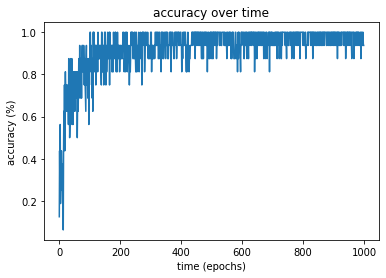

In [47]:
# note that parameters batch_size and epochs are tuned to yield a more accurate model
net.apply(weights_init)
batch_size = 16
epochs = 1000
verbose = False
accuracies = train_net_Adam(train_data, train_target, batch_size, epochs, verbose)
test_net(test_data, test_target, verbose = False)

plt.plot(list(range(epochs)), accuracies)
plt.title('accuracy over time')
plt.xlabel('time (epochs)')
plt.ylabel('accuracy (%)')
plt.show()

# Batch-DLG and Optimal Input Assignment

In [1]:
#@title compute specific batch of flowers
# process input flowers and compute gradient of batch
def batch_grad(flower_indices, verbose = 0):
    n = len(flower_indices)
    # flower_indices = torch.tensor(flower_indices)

    gt_data = torch.tensor(dst.data[flower_indices]).to(device)
    gt_label = torch.tensor(dst.target[flower_indices]).to(device)
    gt_onehot_label = label_to_onehot(gt_label, num_classes=3)

    out = net(gt_data.float())
    loss = criterion(out, gt_onehot_label)
    batch_dy_dx = torch.autograd.grad(loss, net.parameters())
    original_dy_dx = list((_.detach().clone() for _ in batch_dy_dx)) # share the gradients with other clients

    # verifying dy_dx is average of list of flowers
    if (verbose >= 2):
      print(original_dy_dx)
    
    return original_dy_dx, gt_data, gt_label

In [8]:
# DLG algorithm on a given set of flowers and returns the hypothesized input
def batch_DLG(original_dy_dx, n, gt_data_len, gt_onehot_label_len, verbose = 0):

    # identify (data, label) using LBFGS on the squared difference between the original and guessed gradient
    dummy_data = torch.randn(n, gt_data_len).to(device).requires_grad_(True)
    dummy_label = torch.randn(n, gt_onehot_label_len).to(device).requires_grad_(True)
    optimizer_dlg = torch.optim.LBFGS((dummy_data, dummy_label))

    global opt_steps; opt_steps = 0
    for iters in range(100):

        # closure function needed for LBFGS optimizer
        def closure():
            global opt_steps; opt_steps += 1

            # compute gradient of dummy data/label
            optimizer_dlg.zero_grad()
            pred = net(dummy_data)
            dummy_onehot_label = F.softmax(dummy_label, dim=1)
            dummy_loss = criterion(pred, dummy_onehot_label)

            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
            
            # compute loss function, i.e. the SE of the gradients
            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx):
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()

            grad_diff.backward()
            return grad_diff
        
        # perform GD and log information
        optimizer_dlg.step(closure)
        current_loss = closure()
        if (verbose == 2):
            print('current loss: ', iters, "%.4f" % current_loss.item())
            print('dummy data: ', dummy_data)
            print('dummy labels: ', dummy_label)
        
        # if current_loss is small enough, then the model has 'converged'
        if (current_loss < 1e-9):
            break
        
        # setting an upper limit on the number of optimization steps (e.g. limited attacking capability)
        #if (opt_steps >= 80): 
        #    break
    
    return dummy_data, opt_steps

In [9]:
# find best linear sum assignment
def assign_guess(guess, gt_dataset, n, verbose = False):
    cost_matrix = [[torch.sum((guess[i]-gt_dataset[j])**2).item() for j in range(n)] for i in range(n)]
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    best_MSE = sum([cost_matrix[row_ind[i]][col_ind[i]] for i in range(n)]) / n
    if (verbose):
        print('best guessed-actual assignment: ', col_ind)
        print('best_MSE: ', best_MSE)

    guess_perm = [None] * n
    for i in range(n):
        guess_perm[col_ind[i]] = guess[i]

    return guess_perm

# Leakage Statistics

In [10]:
def compute_stats(n_elts, guess_perm, gt_data):
    MSE = 0
    SEs = []
    n_errors = []
    cos_angles = []
    for i in range(n_elts):
        SE = torch.sum((guess_perm[i]-gt_data[i])**2).item()
        SEs.append(SE); MSE += SE

        n_error = (torch.sum((guess_perm[i]-gt_data[i])**2) / (torch.linalg.norm(gt_data[i])**2)).item()
        n_errors.append(n_error)

        cos_angle = (torch.sum(guess_perm[i]*gt_data[i]).item() / (torch.linalg.norm(gt_data[i]) * torch.linalg.norm(guess_perm[i]))).item()
        cos_angles.append(cos_angle)

    MSE /= n_elts

    return SEs, MSE, n_errors, cos_angles

# Training Model with Batch-DLG

In [41]:
def train_net_Adam_DLG(train_data, train_target, batch_size = 32, epochs = 100, verbose = False, dlg_rate = 10):
    train_dst_len = train_data.shape[0]
    optimizer = torch.optim.Adam(net.parameters()) #lr=0.001)

    # statistics
    accuracies = []
    dlg_timestamps = []
    dlg_SEs = []
    dlg_MSE = []
    dlg_n_errors = []
    dlg_cos_angles = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        rand_subset = list(RandomSampler(range(train_dst_len), num_samples=batch_size))
        # print('epoch, randset: ', epoch, rand_subset)
        gt_data = torch.tensor(train_data[rand_subset]).to(device)
        gt_label = torch.tensor(train_target[rand_subset]).to(device)
        gt_onehot_label = label_to_onehot(gt_label, num_classes=3)

        output = net(gt_data.float())
        #print('adam: ', output.tolist(), gt_onehot_label.tolist())
        loss = criterion(output, gt_onehot_label)

        # Perform DLG ---------------------------------------------------------------

        if (epoch%dlg_rate == 0):
            batch_dy_dx = torch.autograd.grad(loss, net.parameters(), retain_graph = True)
            original_dy_dx = list((_.detach().clone() for _ in batch_dy_dx)) # share the gradients with other clients
            guess, steps = batch_DLG(original_dy_dx, batch_size, 4, 3, 1)
            guess_perm = assign_guess(guess, gt_data, batch_size, verbose)
            SEs, MSE, n_errors, cos_angles = compute_stats(batch_size, guess_perm, gt_data)
            dlg_SEs.append(SEs)
            dlg_MSE.append(MSE)
            dlg_n_errors.append(n_errors)
            dlg_cos_angles.append(cos_angles)
            dlg_timestamps.append(epoch)

        # end of DLG ----------------------------------------------------------------

        # issue: running batch_DLG seems to ruin the stored gradients of the parameters
        # inefficient - REMOVE -----------------------------------------------------------------------------
        optimizer.zero_grad()
        loss = criterion(output, gt_onehot_label)
        # end of REMOVE ------------------------------------------------------------------------------------

        loss.backward()
        if (verbose):
            print('current loss: ', loss)
        
        optimizer.step()

        batch_accuracy = torch.sum(torch.eq(torch.argmax(output, dim=1), gt_label)) / batch_size
        accuracies.append(batch_accuracy)
    
    return accuracies, dlg_timestamps, dlg_SEs, dlg_MSE, dlg_n_errors, dlg_cos_angles

# Results

In [42]:
# results of training a model + dlg
net.apply(weights_init)
epochs = 1000
batch_size = 16
dlg_rate = 10
verbose = False
accuracies, dlg_timestamps, dlg_SEs, dlg_MSE, dlg_n_errors, dlg_cos_angles = train_net_Adam_DLG(train_data, train_target, batch_size, epochs, verbose, dlg_rate)
test_net(test_data, test_target, verbose = False)

score: 28/30


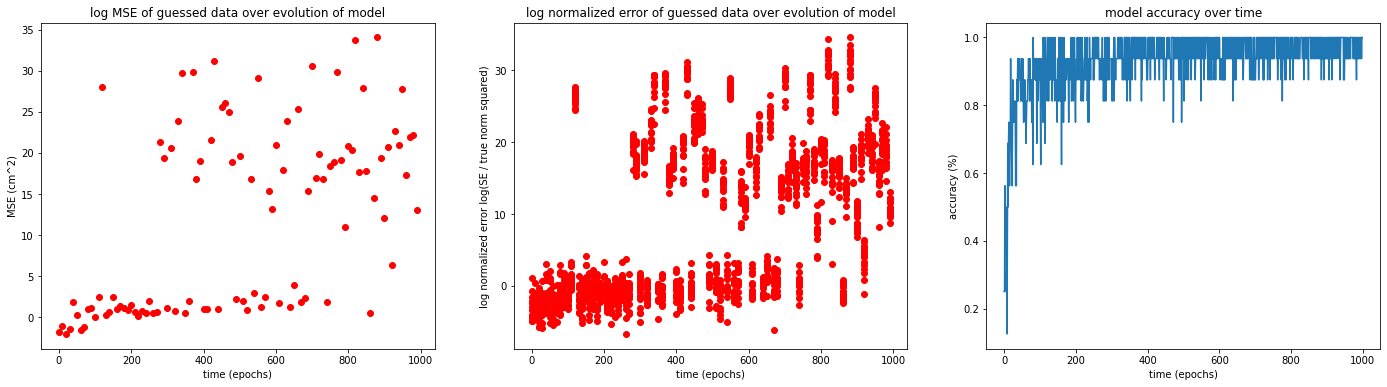

In [45]:
# create summary plots of MSE and normalized errors over time
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

axs[0].plot(dlg_timestamps, torch.log(torch.tensor(dlg_MSE)), 'ro')
axs[0].set(title='log MSE of guessed data over evolution of model', xlabel='time (epochs)', ylabel='MSE (cm^2)')

axs[1].plot(torch.tensor(dlg_timestamps).repeat_interleave(batch_size), torch.log(torch.tensor(dlg_n_errors).view(-1)), 'ro')
axs[1].set(title='log normalized error of guessed data over evolution of model', xlabel='time (epochs)', ylabel='log normalized error log(SE / true norm squared)')

axs[2].plot(list(range(epochs)), accuracies)
axs[2].set(title='model accuracy over time', xlabel='time (epochs)', ylabel='accuracy (%)')

plt.savefig('train_DLG_1000.png', dpi=300)

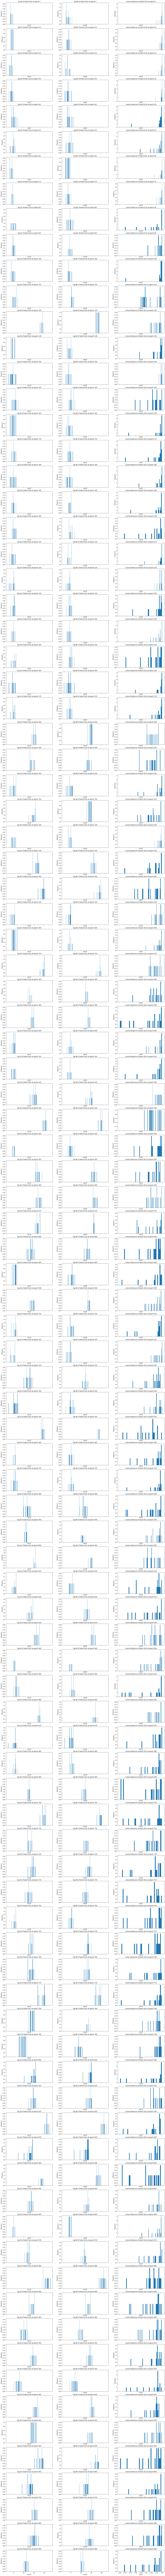

In [46]:
# evolution of SEs, normalized errors, cosine distances
fig, axs = plt.subplots(len(dlg_timestamps), 3, sharex='col', figsize=(24, len(dlg_timestamps)*4))

for i in range(len(dlg_timestamps)):
    axs[i, 0].hist(torch.log(torch.tensor(dlg_SEs[i])), 50)
    axs[i, 0].set(title=f'log SE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log SE', ylabel='frequency')

    axs[i, 1].hist(torch.log(torch.tensor(dlg_n_errors[i])), 50)
    axs[i, 1].set(title=f'log NE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log NE', ylabel='frequency')

    axs[i, 2].hist(dlg_cos_angles[i], 50)
    axs[i, 2].set(title=f'cosine distances of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log SE', ylabel='frequency')

# Notes

In [ ]:
# Todo
# - see if the model can be trained better
